# Lending Club EDA and Modeling

Data Description From Kaggle: 

These files contains complete loan data for all loans issued from 2007 to 2015, including the current loan status (Current, Late, Fully Paid, etc.) and latest payment information. The file containing loan data through the "present" contains complete loan data for all loans issued through the previous completed calendar quarter. Additional features include credit scores, number of finance inquiries, address including zip codes, and state, and collections among others. The file is a matrix of about 2.2M observations and 145 variables. A data dictionary is provided in a separate file. 

- The first dataset was sourced here: https://www.kaggle.com/wendykan/lending-club-loan-data
- The second dataset was sourced here: https://www.kaggle.com/wordsforthewise/lending-club

In this notebook I took the following steps:

1. Import and clean the data
2. EDA 
3. Feature Selection/Creation
4. Modeling
5. Testing

The problem statement that we are solving for is: 

Define a model that can accurately predict the likelihood of default given a set of variables.


In [1]:
#import sqlite3
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import os

import seaborn as sns
sns.set_style('whitegrid')

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, make_scorer, accuracy_score
from sklearn.model_selection import ParameterGrid
#from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from scipy import stats
from xgboost import XGBClassifier

# set random seeds 
from numpy.random import seed

RANDOM_SEED = 2018
seed(RANDOM_SEED)

In [3]:
#Bringing in the original dataset

loan = pd.read_csv('loan.csv',low_memory=False)

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
#set working Directory to where second data set is saved.
os.chdir('../lending_club_loan_dataset2/')


#read in the second dataset
loan2=pd.read_csv('accepted_2007_to_2018Q4.csv',low_memory=False)

#set working Directory to where notebook is saved is saved.
os.chdir('../lending-club-loan-data/')



/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
#Determining the difference in columns

a = list(loan.columns)
b = list(loan2.columns)
list(set(b) - set(a))

['last_fico_range_high',
 'last_fico_range_low',
 'fico_range_low',
 'sec_app_fico_range_low',
 'fico_range_high',
 'sec_app_fico_range_high']

In [6]:
loan.shape

(2260668, 145)

In [7]:
loan2.shape

(2260701, 151)

In [8]:
loan.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,nan,nan,2500,2500,2500.000,36 months,13.560,84.920,C,C1,Chef,10+ years,RENT,55000.000,Not Verified,Dec-2018,Current,n,nan,NaN,debt_consolidation,Debt consolidation,109xx,NY,18.240,0.000,Apr-2001,1.000,nan,45.000,9.000,1.000,4341,10.300,34.000,w,2386.020,2386.020,167.020,167.020,113.980,53.040,0.000,0.000,0.000,Feb-2019,84.920,Mar-2019,Feb-2019,0.000,nan,1,Individual,nan,nan,NaN,0.000,0.000,16901.000,2.000,2.000,1.000,2.000,2.000,12560.000,69.000,2.000,7.000,2137.000,28.000,42000.000,1.000,11.000,2.000,9.000,1878.000,34360.000,5.900,0.000,0.000,140.000,212.000,1.000,1.000,0.000,1.000,nan,2.000,nan,0.000,2.000,5.000,3.000,3.000,16.000,7.000,18.000,5.000,9.000,0.000,0.000,0.000,3.000,100.000,0.000,1.000,0.000,60124.000,16901.000,36500.000,18124.000,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,N,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
1,nan,nan,30000,30000,30000.000,60 months,18.940,777.230,D,D2,Postmaster,10+ years,MORTGAGE,90000.000,Source Verified,Dec-2018,Current,n,nan,NaN,debt_consolidation,Debt consolidation,713xx,LA,26.520,0.000,Jun-1987,0.000,71.000,75.000,13.000,1.000,12315,24.200,44.000,w,29387.750,29387.750,1507.110,1507.110,612.250,894.860,0.000,0.000,0.000,Feb-2019,777.230,Mar-2019,Feb-2019,0.000,nan,1,Individual,nan,nan,NaN,0.000,1208.000,321915.000,4.000,4.000,2.000,3.000,3.000,87153.000,88.000,4.000,5.000,998.000,57.000,50800.000,2.000,15.000,2.000,10.000,24763.000,13761.000,8.300,0.000,0.000,163.000,378.000,4.000,3.000,3.000,4.000,nan,4.000,nan,0.000,2.000,4.000,4.000,9.000,27.000,8.000,14.000,4.000,13.000,0.000,0.000,0.000,6.000,95.000,0.000,1.000,0.000,372872.000,99468.000,15000.000,94072.000,nan,NaN,nan,n

In [9]:
loan2.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,nan,3600.000,3600.000,3600.000,36 months,13.990,123.030,C,C4,leadman,10+ years,MORTGAGE,55000.000,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.910,0.000,Aug-2003,675.000,679.000,1.000,30.000,nan,7.000,0.000,2765.000,29.700,13.000,w,0.000,0.000,4421.724,4421.720,3600.000,821.720,0.000,0.000,0.000,Jan-2019,122.670,NaN,Mar-2019,564.000,560.000,0.000,30.000,1.000,Individual,nan,nan,NaN,0.000,722.000,144904.000,2.000,2.000,0.000,1.000,21.000,4981.000,36.000,3.000,3.000,722.000,34.000,9300.000,3.000,1.000,4.000,4.000,20701.000,1506.000,37.200,0.000,0.000,148.000,128.000,3.000,3.000,1.000,4.000,69.000,4.000,69.000,2.000,2.000,4.000,2.000,5.000,3.000,4.000,9.000,4.000,7.000,0.000,0.000,0.000,3.000,76.900,0.000,0.000,0.000,178050.000,7746.000,2400.000,13734.000,nan,nan,nan,NaN,nan,nan,nan,nan,nan,nan,nan,nan,nan,N,NaN,NaN,NaN,nan,nan,NaN,NaN,NaN,nan,nan,NaN,nan,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
1,68355089,nan,24700.000,24700.000,24700.000,36 months,11.990,820.280,C,C1,Engineer,10+ years,MORTGAGE,65000.000,Not Verified,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.060,1.000,Dec-1999,715.000,719.000,4.000,6.000,nan,22.000,0.000,21470.000,19.200,38.000,w,0.000,0.000,25679.660,25679.660,24700.000,979.660,0.000,0.000,0.000,Jun-2016,926.350,NaN,Mar-2019,699.000,695.000,0.000,nan,1.000,Individual,nan,nan,NaN,0.000,0.000,204396.000,1.000,1.000,0.000,1.000,19.000,18005.000,73.000,2.000,3.000,6472.

In [10]:
#Data Types

loan.dtypes

id                                            float64
member_id                                     float64
loan_amnt                                       int64
funded_amnt                                     int64
funded_amnt_inv                               float64
term                                           object
int_rate                                      float64
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

In [11]:
#Data Types

loan2.dtypes

id                                             object
member_id                                     float64
loan_amnt                                     float64
funded_amnt                                   float64
funded_amnt_inv                               float64
term                                           object
int_rate                                      float64
installment                                   float64
grade                                          object
sub_grade                                      object
emp_title                                      object
emp_length                                     object
home_ownership                                 object
annual_inc                                    float64
verification_status                            object
issue_d                                        object
loan_status                                    object
pymnt_plan                                     object
url                         

In [12]:
#Number of records with each date in Loan2 dataset

loan2[['issue_d']].apply(pd.value_counts) 

,issue_d
Mar-2016,61992
Oct-2015,48631
May-2018,46311
Oct-2018,46305
Aug-2018,46079
Jul-2015,45962
Dec-2015,44343
Aug-2017,43573
Jul-2018,43089
Apr-2018,42928


In [13]:
#number of blanks in issue date for Loan2 dataset
loan2['issue_d'].isnull().sum()

33

In [14]:
#Creating a new date type field for sorting, and removing the blank rows

loan2['issue_d_as_date'] = loan2['issue_d'].fillna('Jan-1900')
loan2['issue_d_as_date'] = pd.to_datetime(loan2['issue_d_as_date'], format='%b-%Y')

loan2 = loan2[loan2['issue_d_as_date']!='1900/01']
loan2['issue_d_as_date'] = loan2['issue_d_as_date'].apply(lambda x: pd.to_datetime(x).strftime('%Y/%m'))
loan2 = loan2.sort_values(by = 'issue_d_as_date', ascending = True )

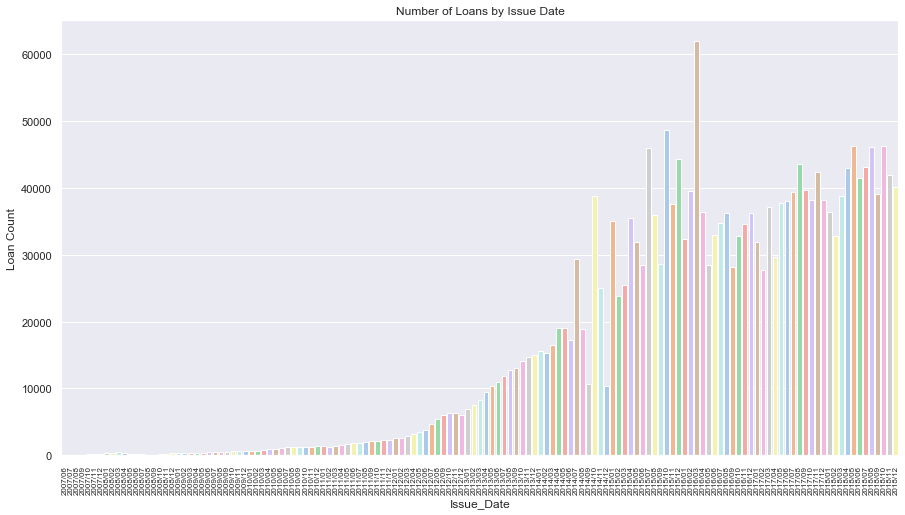

In [15]:
#Distribution of number of loans by issue date

sns.set(rc={'figure.figsize':(15,8)})
sns.countplot(loan2['issue_d_as_date'],palette='pastel')
plt.xlabel("Issue_Date")
plt.ylabel("Loan Count")
plt.xticks(rotation=90, fontsize = 8)
plt.title("Number of Loans by Issue Date")
plt.show()

In [16]:
#Checking null counts

loan.isnull().sum() 

id                                            2260668
member_id                                     2260668
loan_amnt                                           0
funded_amnt                                         0
funded_amnt_inv                                     0
term                                                0
int_rate                                            0
installment                                         0
grade                                               0
sub_grade                                           0
emp_title                                      166969
emp_length                                     146907
home_ownership                                      0
annual_inc                                          4
verification_status                                 0
issue_d                                             0
loan_status                                         0
pymnt_plan                                          0
url                         

In [17]:
nulls = pd.DataFrame(round(loan.isnull().sum()/len(loan.index)*100,2),columns=['null_percent'])

null_prct = nulls[nulls['null_percent']!=0.00].sort_values('null_percent',ascending=False)
null_prct

,null_percent
id,100.000
url,100.000
member_id,100.000
orig_projected_additional_accrued_interest,99.630
hardship_length,99.530
hardship_reason,99.530
hardship_status,99.530
deferral_term,99.530
hardship_amount,99.530
hardship_start_date,99.530


In [18]:
nulls2 = pd.DataFrame(round(loan2.isnull().sum()/len(loan2.index)*100,2),columns=['null_percent'])

null2_prct = nulls2[nulls2['null_percent']!=0.00].sort_values('null_percent',ascending=False)
null2_prct

,null_percent
member_id,100.000
orig_projected_additional_accrued_interest,99.620
hardship_dpd,99.520
hardship_status,99.520
deferral_term,99.520
hardship_amount,99.520
hardship_start_date,99.520
hardship_end_date,99.520
payment_plan_start_date,99.520
hardship_length,99.520


In [19]:
list(null2_prct.index)

['member_id',
 'orig_projected_additional_accrued_interest',
 'hardship_dpd',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_loan_status',
 'hardship_type',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 'hardship_reason',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'settlement_term',
 'sec_app_mths_since_last_major_derog',
 'sec_app_revol_util',
 'sec_app_fico_range_low',
 'revol_bal_joint',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_open_acc',
 'sec_app_mort_acc',
 'sec_app_inq_last_6mths',
 'sec_app_earliest_cr_line',
 'sec_app_fico_range_high',
 'verification_status_joint',
 'annual_inc_joint',
 'dti_joint',
 'desc',
 'mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_

There is a significant amount of NaN values. This will limit our ability to use Neural Networks if we cannot safely impute nulls. The below effort is to weed out unnecessary columns based on null count, data redundancy, and some operational data. Any columns with more than 20% null values to be dropped.

In [20]:
#removing useless fields

col = ['member_id',
 'orig_projected_additional_accrued_interest',
 'hardship_dpd',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_date',
 'hardship_length',
 'hardship_loan_status',
 'hardship_type',
 'hardship_payoff_balance_amount',
 'hardship_last_payment_amount',
 'hardship_reason',
 'debt_settlement_flag_date',
 'settlement_status',
 'settlement_date',
 'settlement_amount',
 'settlement_percentage',
 'settlement_term',
 'sec_app_mths_since_last_major_derog',
 'sec_app_revol_util',
 'sec_app_fico_range_low',
 'revol_bal_joint',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_open_acc',
 'sec_app_mort_acc',
 'sec_app_inq_last_6mths',
 'sec_app_earliest_cr_line',
 'sec_app_fico_range_high',
 'verification_status_joint',
 'annual_inc_joint',
 'dti_joint',
 'desc',
 'mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_last_major_derog',
 'mths_since_recent_revol_delinq',
 'next_pymnt_d',
 'mths_since_last_delinq',
 'il_util',
 'mths_since_rcnt_il',
 'all_util',
 'total_bal_il',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'open_il_12m',
 'open_act_il',
 'open_acc_6m',
 'open_il_24m']


loan2 = loan2.drop(col, axis = 1)
print(loan.shape)
print(loan2.shape)

(2260668, 145)
(2260668, 94)


As a result of the above highlevel assessment of the secondary dataset it appears the second data set is the better choice due to the issue_d field being populated with actual dates. All other fields are the same


### Summary level stats

In [21]:
loan['loan_status'].value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

In [22]:
loan2['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

In [23]:
# Setting up target feature for what loans are in default, for easier visualization.

target = [1 if i=='Default' or i =='Charged Off' or i=='Does not meet the credit policy. Status:Charged Off' else 0 for i in loan['loan_status']]
loan['target'] = target
loan['target'].value_counts()

0    1998221
1     262447
Name: target, dtype: int64

In [24]:
# Setting up target feature for what loans are in default, for easier visualization.

target = [1 if i=='Default' or i =='Charged Off' or i=='Does not meet the credit policy. Status:Charged Off' else 0 for i in loan2['loan_status']]
loan2['target'] = target
loan2['target'].value_counts()

0    1991308
1     269360
Name: target, dtype: int64

In [25]:
#Removing loan dataset

del loan

In [26]:
#Renaming loan2 to loan

loan = loan2.copy()
del loan2

PLEASE NOTE: Moving forward with the second dataset from here

In [27]:
#Null counts of default loans

default_nulls = pd.DataFrame(round(loan[loan['target']==1].isnull().sum()/len(loan[loan['target']==1].index)*100,2),columns=['null_percent'])

default_null_prct = default_nulls[default_nulls['null_percent']!=0.00].sort_values('null_percent',ascending=False)
default_null_prct

,null_percent
mths_since_recent_inq,9.900
num_tl_120dpd_2m,9.160
emp_title,8.360
emp_length,7.850
mo_sin_old_il_acct,7.160
pct_tl_nvr_dlq,4.120
avg_cur_bal,4.120
num_actv_bc_tl,4.110
tot_hi_cred_lim,4.110
num_tl_op_past_12m,4.110


In [28]:
#Percent Default to Not In Default

print('% of Loans in Default:',round((sum(loan['target']==1)/len(loan['target'])*100),2))
print('% of Loans Not in Default::',round((1-sum(loan['target']==1)/len(loan['target']))*100,2))

% of Loans in Default: 11.92
% of Loans Not in Default:: 88.08


In [29]:
#Summary statistics of loans in default

default_loans = loan[loan['target']==1]
default_loans.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,target
count,269360.000,269360.000,269360.000,269360.000,269360.000,269360.000,269289.000,269357.000,269360.000,269360.000,269357.000,269357.000,269357.000,269360.000,269174.000,269357.000,269360.000,269360.000,269360.000,269360.000,269360.000,269360.000,269360.000,269360.000,269360.000,269360.000,269360.000,269360.000,269332.000,269360.000,269357.000,258281.000,258281.000,258281.000,261713.000,258274.000,258767.000,258600.000,269332.000,269357.000,250071.000,258280.000,258280.000,258281.000,261713.000,258969.000,242697.000,258281.000,258281.000,258281.000,260335.000,258281.000,258281.000,258281.000,258281.000,258281.000,260335.000,244675.000,258281.000,258281.000,258281.000,258259.000,258689.000,269026.000,269349.000,258281.000,261713.000,261713.000,258281.000,269360.000
mean,15547.817,15539.057,15503.605,15.708,464.692,70398.832,20.154,0.351,687.831,691.831,0.789,11.896,0.247,15386.919,54.757,24.702,1.422,1.422,8281.280,8262.723,4383.677,2685.434,4.629,1207.540,201.279,471.984,568.573,507.285,0.022,1.000,0.006,239.565,118844.440,28947.872,5.326,10934.288,7679.336,63.664,0.010,19.377,123.070,171.991,11.365,6.899,1.371,20.673,6.070,0.537,3.829,6.108,4.818,7.936,8.662,8.577,14.529,6.036,11.931,0.001,0.004,0.099,2.493,93.981,49.983,0.154,0.060,146619.979,49308.402,18538.280,42024.145,1.000
std,8814.732,8811.315,8822.389,4.906,262.793,65385.215,11.825,0.937,25.956,25.956,1.047,5.640,0.656,19285.016,23.882,12.124,152.838,152.838,6676.854,6675.288,4120.458,2725.693,16.759,1847.546,329.907,570.753,54.263,189.714,0.162,0.000,0.082,1774.962,134604.626,28011.361,3.424,13255.883,11998.922,27.612,0.113,979.073,54.241,94.773,14.556,7.919,1.826,27.918,5.634,1.344,2.367,3.544,3.023,4.779,7.651,4.702,8.163,3.441,5.634,0.033,0.065,0.525,1.983,8.806,35.812,0.404,0.448,151501.936,44848.729,18442.049,41616.543,0.000
min,500.000,500.000,0.000,5.310,15.910,0.000,0.000,0.000,615.000,619.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,2.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10.500,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000
25%,9000.000,9000.000,8975.000,12.290,275.070,43000.000,13.540,0.000,670.000,674.000,0.000,8.000,0.000,5980.000,37.400,16.000,0.000,0.000,3497.272,3480.667,1518.228,852.985,0.000,0.000,0.000,255.030,524.000,520.000,0.000,1.000,0.000,0.000,27448.000,13100.000,3.000,2797.000,1101.000,43.600,0.000,0.000,92.000,109.000,3.000,2.000,0.000,5.000,2.000,0.000,2.000,4.000,3.000,4.000,3.000,5.000,9.000,4.000,8.000,0.000,0.000,0.000,1.000,90.900,20.000,0.000,0.000,44769.000,21634.000,6900.000,15000.000,1.000
50%,14300.000,14250.000,14125.000,15.050,402.540,60000.000,19.750,0.000,680.000,684.000,0.000,11.000,0.000,11065.000,55.500,23.000,0.000,0.000,6507.220,6492.745,3153.135,1795.610,0.000,588.620,

In [30]:
#Summary statistics of loans 'Not' in default

non_default_loans = loan[loan['target']==0]
non_default_loans.describe()

,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,target
count,1991308.000,1991308.000,1991308.000,1991308.000,1991308.000,1991304.000,1989668.000,1991282.000,1991308.000,1991308.000,1991281.000,1991282.000,1991282.000,1991308.000,1989692.000,1991282.000,1991308.000,1991308.000,1991308.000,1991308.000,1991308.000,1991308.000,1991308.000,1991308.000,1991308.000,1991308.000,1991308.000,1991308.000,1991191.000,1991308.000,1991282.000,1932111.000,1932111.000,1932111.000,1948925.000,1932048.000,1926966.000,1925997.000,1991191.000,1991282.000,1871526.000,1932111.000,1932111.000,1932111.000,1948925.000,1928287.000,1722536.000,1932111.000,1932111.000,1932111.000,1941743.000,1932111.000,1932111.000,1932111.000,1932110.000,1932111.000,1941743.000,1862336.000,1932111.000,1932111.000,1932111.000,1931978.000,1926600.000,1990277.000,1991214.000,1932111.000,1948925.000,1948925.000,1932111.000,1991308.000
mean,14979.177,14974.383,14958.487,12.739,443.252,79019.600,18.644,0.301,700.043,704.043,0.548,11.574,0.191,16830.456,49.740,24.090,4775.756,4774.705,12596.747,12578.639,10198.626,2397.023,1.098,0.000,0.000,3829.382,703.770,698.299,0.018,1.000,0.004,231.818,145653.383,35326.025,4.414,13897.169,11893.130,57.126,0.008,11.422,126.094,182.762,14.380,8.484,1.580,25.405,7.159,0.495,3.656,5.566,4.768,7.698,8.380,8.202,13.935,5.517,11.588,0.001,0.003,0.081,2.021,94.132,41.422,0.125,0.045,182470.027,51253.176,23818.934,43960.318,0.000
std,9237.786,9236.186,9239.322,4.712,267.658,117606.306,14.464,0.857,33.588,33.589,0.858,5.640,0.558,23394.536,24.763,11.967,7648.406,7647.497,10151.328,10146.582,8502.673,2671.607,10.941,0.000,0.000,6303.290,58.896,69.256,0.149,0.000,0.068,9046.728,163606.862,37677.933,3.112,16827.063,17061.967,28.623,0.104,685.176,53.256,97.357,17.864,9.352,1.914,32.825,5.998,1.351,2.318,3.356,3.040,4.690,7.319,4.680,8.019,3.268,5.644,0.026,0.055,0.489,1.802,9.066,36.150,0.359,0.367,184815.787,50548.044,23482.046,45510.301,0.000
min,500.000,500.000,0.000,5.310,4.930,0.000,-1.000,0.000,610.000,614.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,8000.000,8000.000,8000.000,9.170,248.820,47000.000,11.700,0.000,675.000,679.000,0.000,8.000,0.000,5946.000,30.800,15.000,0.000,0.000,4792.520,4778.280,3500.000,713.507,0.000,0.000,0.000,320.050,674.000,670.000,0.000,1.000,0.000,0.000,29351.000,14900.000,2.000,3126.000,1839.000,34.400,0.000,0.000,96.000,117.000,4.000,3.000,0.000,6.000,2.000,0.000,2.000,3.000,3.000,4.000,3.000,5.000,8.000,3.000,8.000,0.000,0.000,0.000,1.000,91.400,0.000,0.000,0.000,51744.000,20792.000,8500.000,15000.000,0.000
50%,12550.000,12500.000,12500.000,12.130,375.430,65200.000,17.580,0.000,695.000,699.000,0.000,11.000,0.000,11361.000,49.

### Visualizations

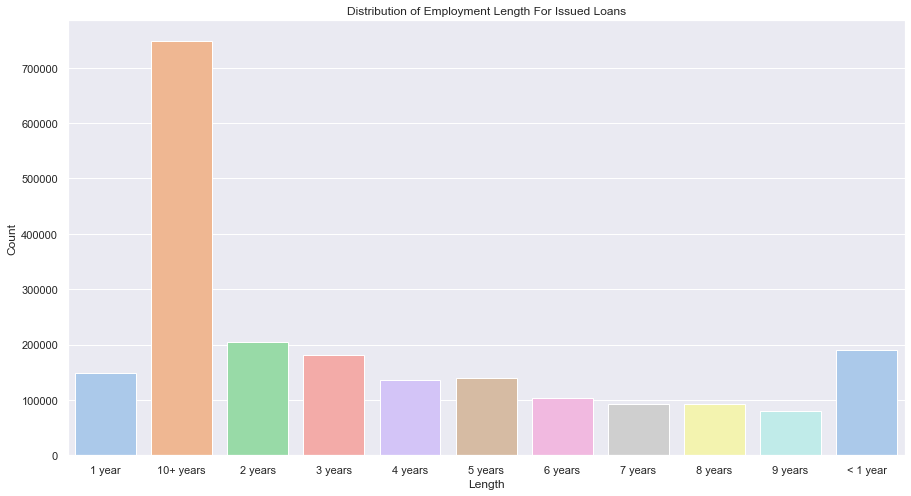

In [31]:
#Distribution of employment length for issued loans

sns.set(rc={'figure.figsize':(15,8)})
sns.countplot(loan['emp_length'].sort_values(),palette='pastel')
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Employment Length For Issued Loans")
plt.show()

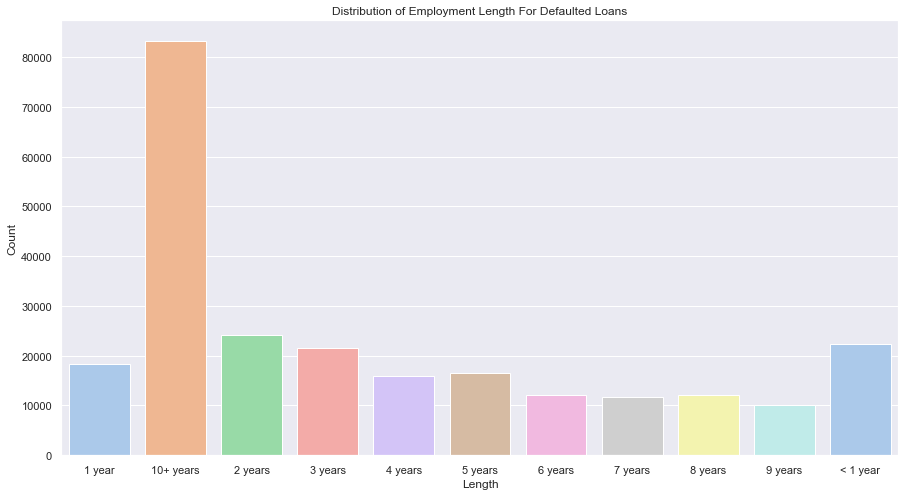

In [32]:
#Distribution of employment length for defaulted loans

sns.set(rc={'figure.figsize':(15,8)})
sns.countplot(default_loans['emp_length'].sort_values(),palette='pastel')
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Employment Length For Defaulted Loans")
plt.show()

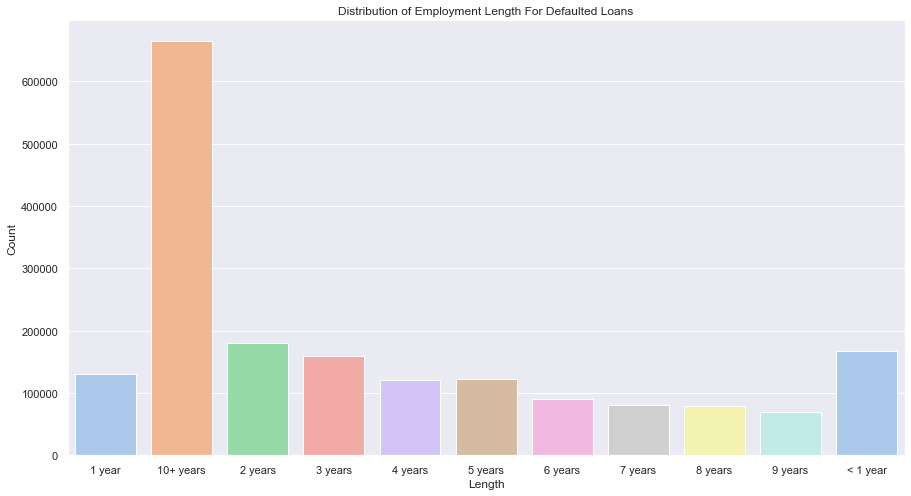

In [33]:
#Distribution of employment length for non-defaulted loans

sns.set(rc={'figure.figsize':(15,8)})
sns.countplot(non_default_loans['emp_length'].sort_values(),palette='pastel')
plt.xlabel("Length")
plt.ylabel("Count")
plt.title("Distribution of Employment Length For Defaulted Loans")
plt.show()

#### Loan amount by default status

Interestly those in default had no payment plan

Text(0, 0.5, 'Loan Amount')

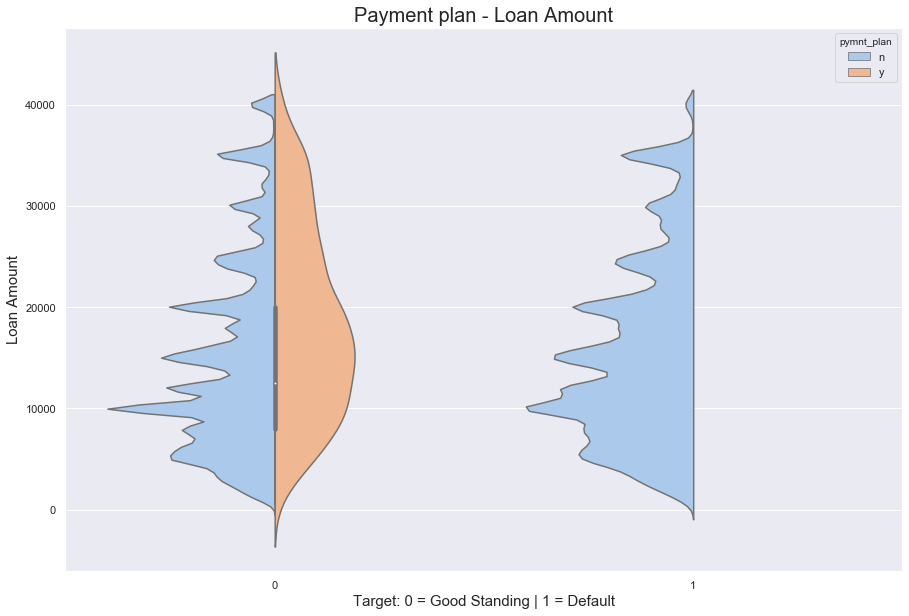

In [34]:
sns.set(rc={'figure.figsize':(15,10)})
sns.violinplot(x="target",y="loan_amnt",data=loan, hue="pymnt_plan", split=True,palette='pastel')
plt.title("Payment plan - Loan Amount", fontsize=20)
plt.xlabel("Target: 0 = Good Standing | 1 = Default", fontsize=15)
plt.ylabel("Loan Amount", fontsize=15)

Text(0.5, 1.0, 'Distribution of Loan Amount by Loan Status')

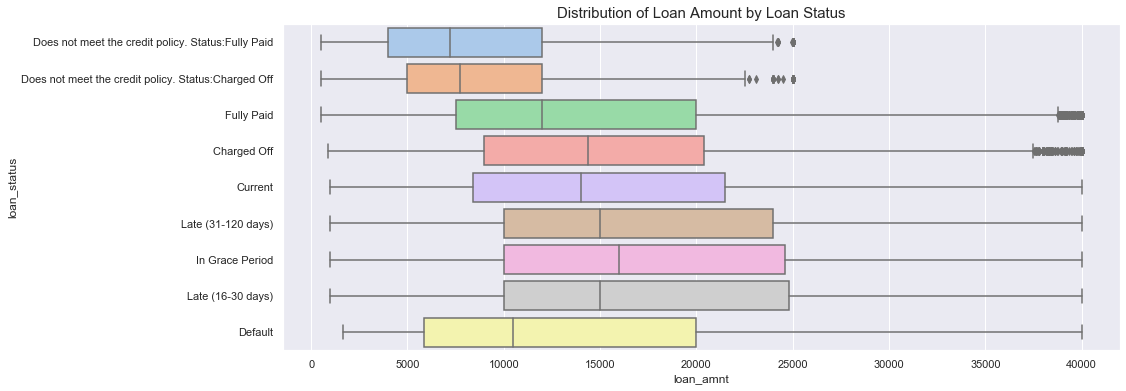

In [35]:
#Boxplot of loan amount by loan status

sns.set(rc={'figure.figsize':(15,6)})
sns.boxplot(x='loan_amnt', y='loan_status', data=loan, palette='pastel')
plt.title("Distribution of Loan Amount by Loan Status", fontsize=15)

Text(0.5, 1.0, 'Distribution of Loan Amount by Loan Status and Grade')

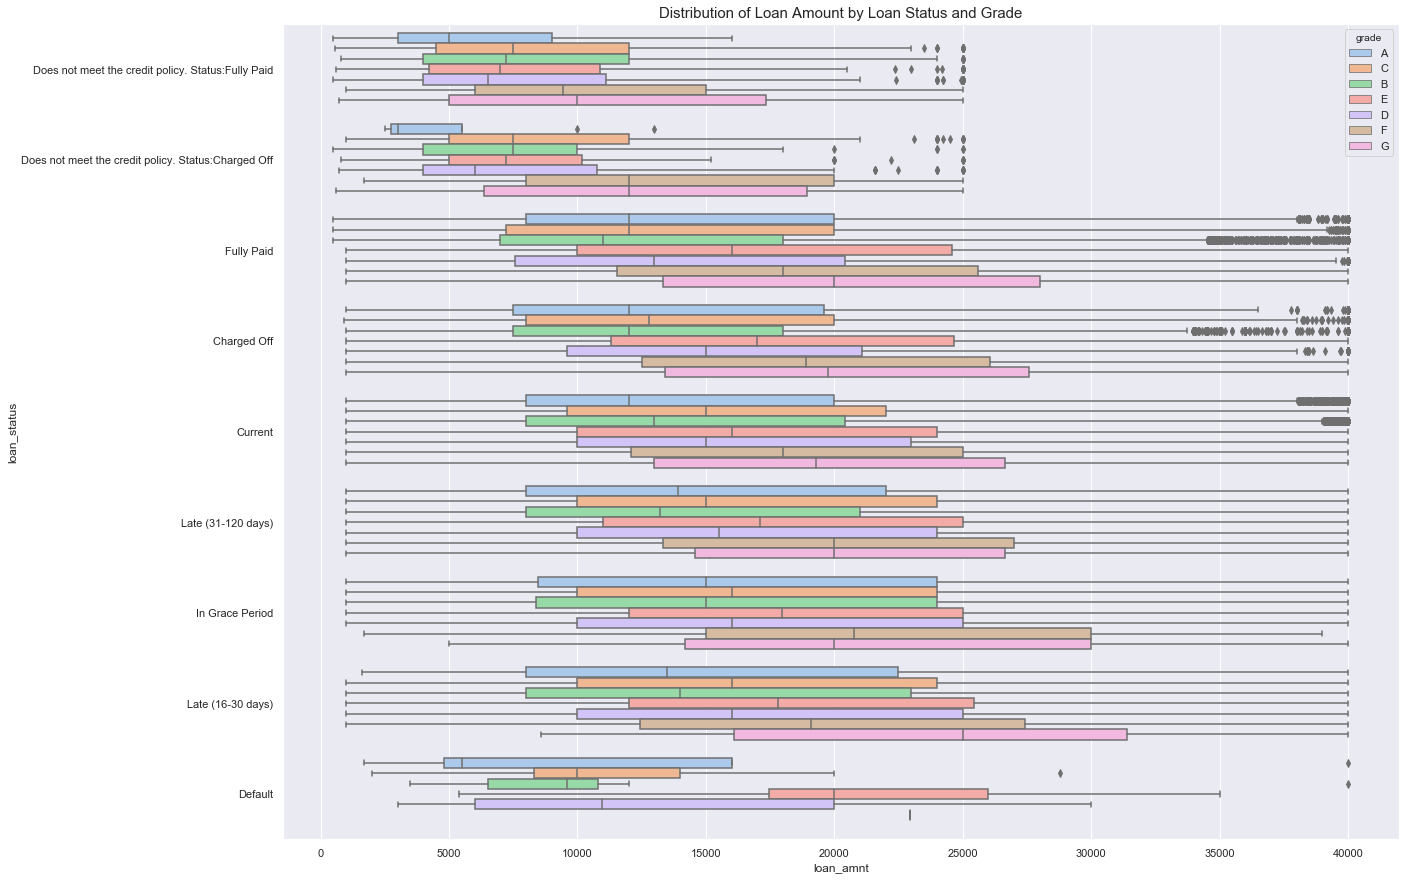

In [36]:
#Boxplot of loan amount by loan status

sns.set(rc={'figure.figsize':(20,15)})
sns.boxplot(x='loan_amnt', y='loan_status', data=loan, hue = 'grade',  palette='pastel')
plt.title("Distribution of Loan Amount by Loan Status and Grade", fontsize=15)

Text(0.5, 1.0, 'Count of Each Loan Grade')

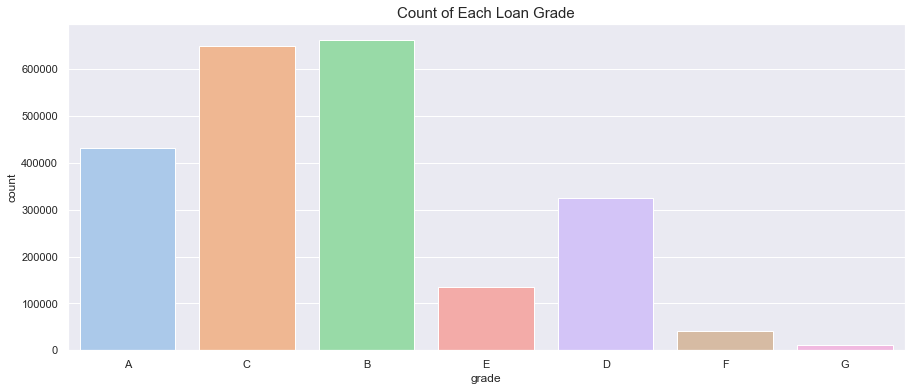

In [37]:
#Grade of loans Lending Club normally issues:

sns.set(rc={'figure.figsize':(15,6)})
sns.countplot(loan['grade'], palette='pastel')
plt.title("Count of Each Loan Grade", fontsize=15)

Text(0, 0.5, 'Average Loan Amount')

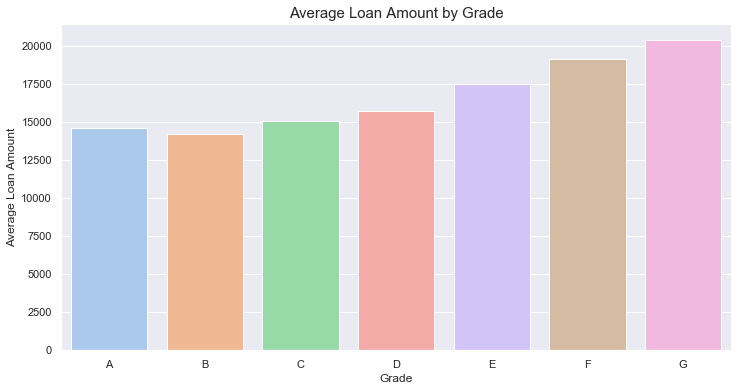

In [38]:
#Average loan amounts by grade:

loan_grades = loan.groupby("grade").mean().reset_index()

sns.set(rc={'figure.figsize':(12,6)})
sns.barplot(x='grade', y='loan_amnt', data=loan_grades, palette='pastel')
plt.title("Average Loan Amount by Grade", fontsize=15)
plt.xlabel("Grade", fontsize=12)
plt.ylabel("Average Loan Amount", fontsize=12)

Text(0, 0.5, 'Average Interest Rate')

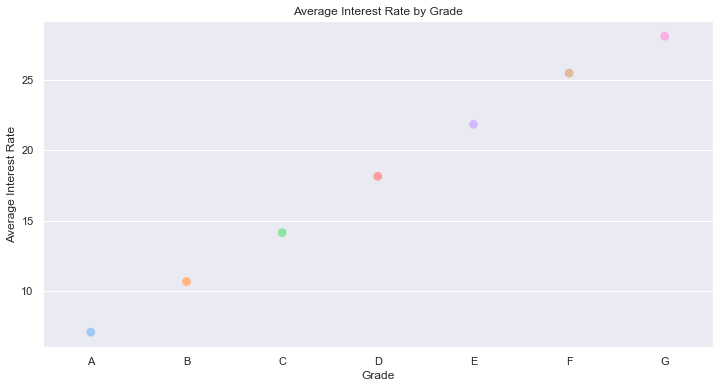

In [39]:
#Avg interest rate by grade:

loan_grades = loan.groupby("grade").mean().reset_index()

sns.set(rc={'figure.figsize':(12,6)})
sns.pointplot(x='grade', y='int_rate', data=loan_grades, palette='pastel')
plt.title("Average Interest Rate by Grade", fontsize=12)
plt.xlabel("Grade", fontsize=12)
plt.ylabel("Average Interest Rate", fontsize=12)

Grade B loans are the highest in quantity but lowest in avg loan amount value. Interest rates rise commensurately with loan quality and amount.

Text(0, 0.5, 'Loan Amount')

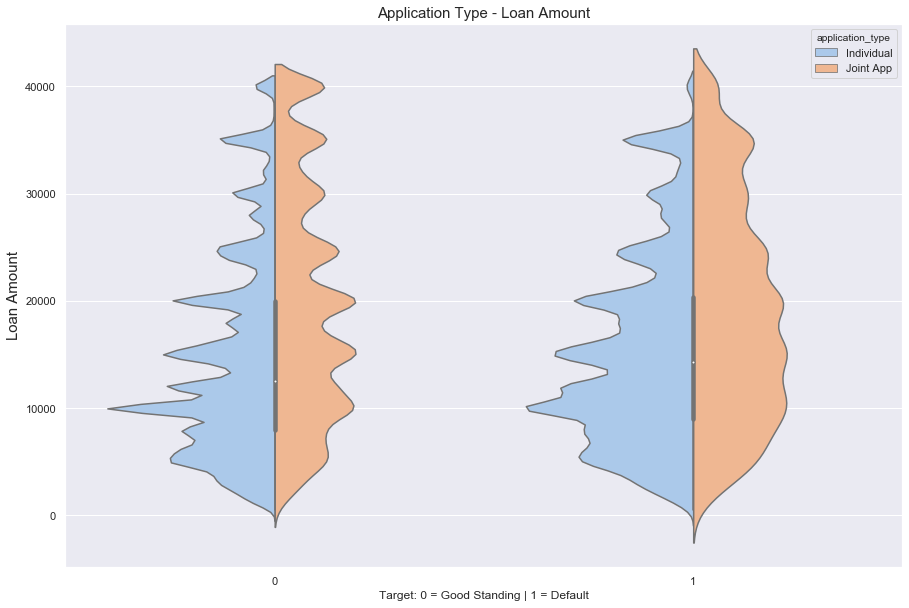

In [40]:
#Distribution of loan amounts by loan_status

sns.set(rc={'figure.figsize':(15,10)})
sns.violinplot(x="target",y="loan_amnt",data=loan, hue="application_type", split=True,palette='pastel')
plt.title("Application Type - Loan Amount", fontsize=15)
plt.xlabel("Target: 0 = Good Standing | 1 = Default", fontsize=12)
plt.ylabel("Loan Amount", fontsize=15)

Text(0.5, 1.0, 'Distribution of Interest Rates by Default vs. Non-Default')

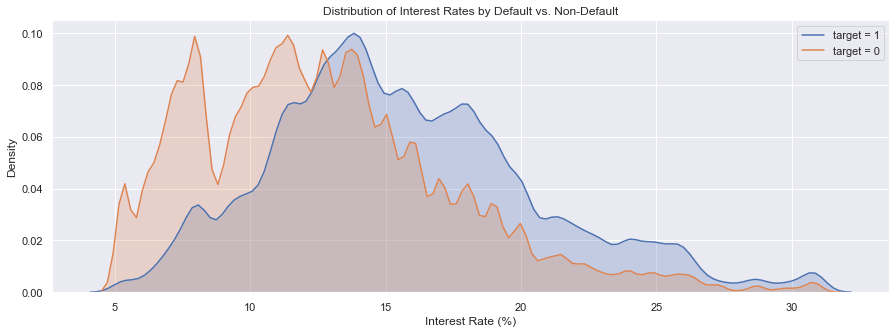

In [41]:
#Overall distribution of interest rates for default and non-default loans:

sns.set(rc={'figure.figsize':(15,5)})
sns.kdeplot(loan.loc[loan['target'] == 1, 'int_rate'], label = 'target = 1',shade=True)
sns.kdeplot(loan.loc[loan['target'] == 0, 'int_rate'], label = 'target = 0',shade=True);
plt.xlabel('Interest Rate (%)',fontsize=12)
plt.ylabel('Density',fontsize=12)
plt.title('Distribution of Interest Rates by Default vs. Non-Default',fontsize=12)

Text(0.5, 1.0, 'Number of defaulted loans per state')

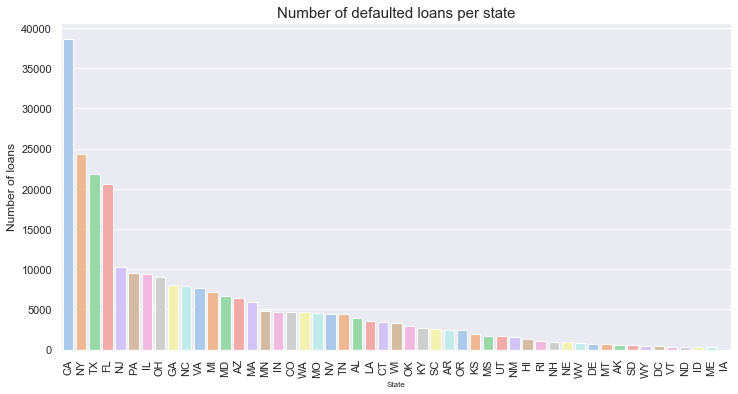

In [42]:
#Which state has the most defaults?


state_default = loan[loan['target']==1]['addr_state']

sns.set(rc={'figure.figsize':(12,6)})
sns.countplot(state_default, order=state_default.value_counts().index, palette='pastel')
plt.xlabel('State',fontsize=8, rotation = 0)
plt.xticks(rotation=90)
plt.ylabel('Number of loans',fontsize=12)
plt.title('Number of defaulted loans per state',fontsize=15)

Text(0.5, 1.0, 'Number of not-defaulted loans per state')

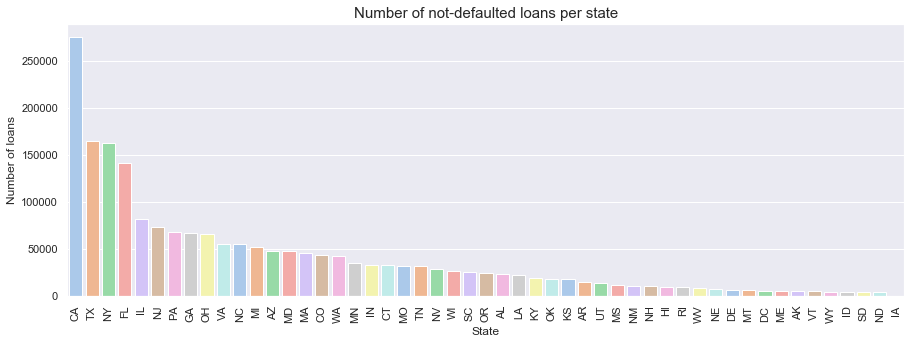

In [43]:
#Count of non-default by state

state_non_default = loan[loan['target']==0]['addr_state']

sns.set(rc={'figure.figsize':(15,5)})
sns.countplot(state_non_default, order=state_non_default.value_counts().index, palette='pastel')
plt.xlabel('State',fontsize=12)
plt.xticks(rotation=90)
plt.ylabel('Number of loans',fontsize=12)
plt.title('Number of not-defaulted loans per state',fontsize=15)

#### Summary of Findings Thus Far:

- Since most of the customers have been employed for 10+ years, the majority of Lending Club's customers are 30+ years of age.
- Interest rate varies wildly, reaching nearly 40% for high-risk loans
- Grade A has the lowest interest rate with an average interest rate below 5%
- Grade G has the highest interest rate above 25%
- The lower the grade, the higher loan amount loan issued
- Fully Paid loans tend to be smaller. This could be due to the age of the loans
- Defaulted loans are highest for oldest and youngest demographic based on years of employment.
- In Grace Period and Late(16~30 days) have the highest loan amount and mean.
- Most of the loans have interest rates between 12% and 18%
- California has the most non-defaulted loans out of all the states in US, with Texas and California sharing the most defaulted loans of all states in the US.
- States are not a distinguishing feature for predicting the defaulted loans.

### Feature Engineering

In [44]:
#Generally, loans are divided by income to determine if they borrower can afford it. 

loan['loan_2_income_ratio'] = loan['loan_amnt']/loan['annual_inc']
loan['loan_2_income_ratio'].head()

1654413     nan
1654392   0.300
1654393   0.147
1654394   0.033
1654395   0.179
Name: loan_2_income_ratio, dtype: float64

In [45]:
#It is believed by our experts if the lenders give less than the amount requested, it would be a bad sign. 

loan['apprvd_loan_amt_ratio'] = (loan['loan_amnt']-loan['funded_amnt'])/loan['loan_amnt']
#loan[loan['apprvd_loan_amt_ratio']!=0]

### Cleaning Data

In [ ]:
loan.dtypes

### Modeling

In [ ]:
#Cleaning up ghost artifacts

import gc
gc.collect()